https://github.com/felipemaiapolo/cit

For the simulated null, the plotted values are average rejection rates across companies. 

For the true run, it's combined across companies.

In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
plt.rcParams["svg.fonttype"] = 'none'

In [110]:
names = {'kci': 'KCI', 'kci_a': 'SplitKCI (A only)', 'circe': 'CIRCE', 'gcm': 'GCM', 'rbpt2_ub': 'RBPT2\'',
            'rbpt2': 'RBPT2', 'kci_ab': 'SplitKCI', 'rbpt': 'RBPT'}
colors = {'kci': '#0072B2', 'kci_a': '#009E73',
          'circe': '#821651', 'gcm': '#E69F00', 
          'rbpt': '#D55E96',
          'rbpt2_ub': '#D55E00', 'rbpt2': '#D53200', 'kci_ab': '#000000'}
# re-naming for more convenient plotting
for k, v in names.items():
     colors[v] = colors[k]
state_name = {'ca': 'California', 'il': 'Illinois', 'tx': 'Texas', 'mo': 'Missouri'}

In [60]:
simulated_pvals = torch.load(
    os.path.join(os.environ['SCRATCH'], 
                 'splitkci_testing_results/car_insurance/car_pvals_simulated.pt'), weights_only=False)
true_pvals = torch.load(
    os.path.join(os.environ['SCRATCH'],
                 'splitkci_testing_results/car_insurance/car_pvals_true.pt'), weights_only=False)

# Simulated H0

In [145]:
algorithms = simulated_pvals['ca']['Safeco Ins Co Of Amer'].keys()

alpha = 0.05
rejection_rates = {(i, j): {seed: [] for seed in range(50)} for j in algorithms for i in simulated_pvals.keys()}

for i in simulated_pvals.keys():
    for c in simulated_pvals[i].keys():
        for j in simulated_pvals[i][c].keys():
            for seed, val in enumerate(simulated_pvals[i][c][j]):
                rejection_rates[(i, j)][seed].append(val <= alpha)
                
for i in simulated_pvals.keys():
    for j in algorithms:
        for seed in range(50):
            rejection_rates[(i, j)][seed] = np.mean(rejection_rates[(i, j)][seed])
        rejection_rates[(i, j)] = list(rejection_rates[(i, j)].values())
        

rejection_rates = pd.DataFrame.from_dict(rejection_rates)
df = pd.DataFrame([(state_name[i], names[j], v) for (i, j), values in rejection_rates.items() for v in values],
                  columns=['State', 'Algorithm', 'avg. reject rate'])


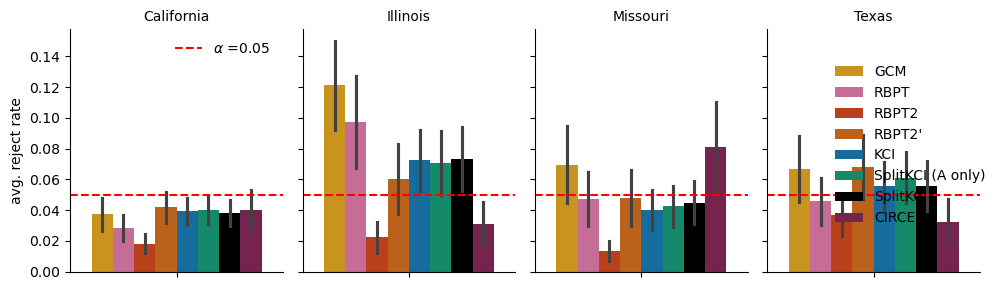

In [146]:
grid = sns.catplot(data=df, hue='Algorithm', y='avg. reject rate', col='State', kind='bar',
                   errorbar='se', alpha=1, palette=colors)
axes = grid.axes.flatten()
for i, ax in enumerate(axes):
    if i == 0:
        ax.axhline(alpha, ls='--', c='r', label=fr'$\alpha$ ={alpha}')
    else:
        ax.axhline(alpha, ls='--', c='r')

grid.set_titles("{col_name}")
grid.legend.set_title("")
axes[0].legend(frameon=False)
grid.fig.set_size_inches(10, 3)
plt.tight_layout()
plt.savefig('figs/cars_sim.svg', transparent=True)
plt.show()

# Actual p-vals

In [148]:
algorithms = true_pvals['ca']['all'].keys()

alpha = 0.05
pvals = {(i, j): {seed: [] for seed in range(1)} for j in algorithms for i in true_pvals.keys()}

for i in true_pvals.keys():
    for c in true_pvals[i].keys():
        for j in true_pvals[i][c].keys():
            for seed, val in enumerate(true_pvals[i][c][j]):
                pvals[(i, j)][seed].append(val)
                
for i in true_pvals.keys():
    for j in algorithms:
        for seed in range(1):
            pvals[(i, j)][seed] = np.mean(pvals[(i, j)][seed])
        pvals[(i, j)] = list(pvals[(i, j)].values())
        

pvals = pd.DataFrame.from_dict(pvals)
df = pd.DataFrame([(state_name[i], names[j], v) for (i, j), values in pvals.items() for v in values],
                  columns=['State', 'Algorithm', 'p-value'])


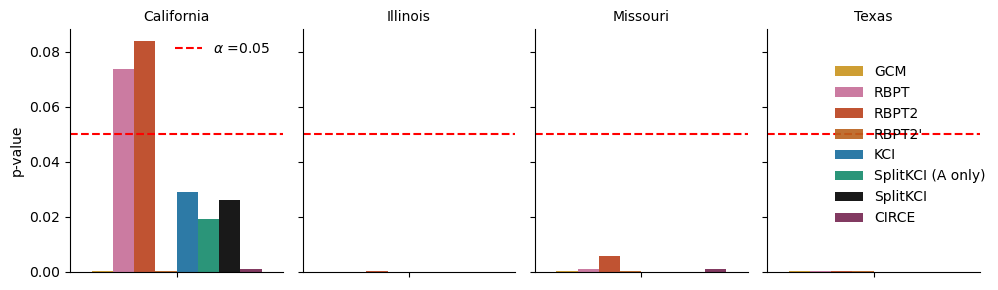

In [149]:
grid = sns.catplot(data=df, hue='Algorithm', y='p-value', col='State', kind='bar',
                   errorbar='se', alpha=0.9, palette=colors)
axes = grid.axes.flatten()
for i, ax in enumerate(axes):
    if i == 0:
        ax.axhline(alpha, ls='--', c='r', label=fr'$\alpha$ ={alpha}')
    else:
        ax.axhline(alpha, ls='--', c='r')

grid.set_titles("{col_name}")
grid.legend.set_title("")
axes[0].legend(frameon=False)
grid.fig.set_size_inches(10, 3)
plt.tight_layout()
plt.savefig('figs/cars_true.svg', transparent=True)
plt.show()